## Calibration of Sumo model in python

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
import scipy as sp
from dynamita.sumo import *
import time
import pandas as pd  

In [3]:
#Provide the installation path and the license file
sumo = Sumo(sumoPath="C:/Users/zerualem/AppData/Local/Dynamita/Sumo16", licenseFile=r"networklicense.sumolic")

License OK...


In [4]:
# Define data communication interval
def datacomm_callback(sumo):
    t.append(sumo.core.csumo_var_get_time_double(sumo.handle))
    #snhx.append(sumo.core.csumo_var_get_pvtarray_pos(sumo.handle, snhx_pos, 0))
    for i in range(6):
        snhx[i].append(sumo.core.csumo_var_get_pvtarray_pos(sumo.handle, snhx_pos, i))
        sno2[i].append(sumo.core.csumo_var_get_pvtarray_pos(sumo.handle, sno2_pos, i))
        sno3[i].append(sumo.core.csumo_var_get_pvtarray_pos(sumo.handle, sno3_pos, i))
        
    return 0

In [5]:
# Define function to load the model
def loadModel():
    sumo.unload_model()
    if not sumo.load_model('GSBR011518.sumo'):
        print ('Model successfuly loaded!')
        sumo.register_datacomm_callback(datacomm_callback)
        sumo.core.csumo_command_send(sumo.handle, b'execute script_Initialize.scs;')

In [6]:
def getVars():
    snhx_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__GranularSBR__SNHx')
    sno2_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__GranularSBR__SNO2')
    sno3_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__GranularSBR__SNO3')
    
    return (snhx_pos,sno2_pos,sno3_pos)

In [7]:
loadModel()
snhx_pos,sno2_pos,sno3_pos=getVars()
print(snhx_pos)
print(sno2_pos)
print(sno3_pos)

No model is loaded
Model successfuly loaded!
86
87
88


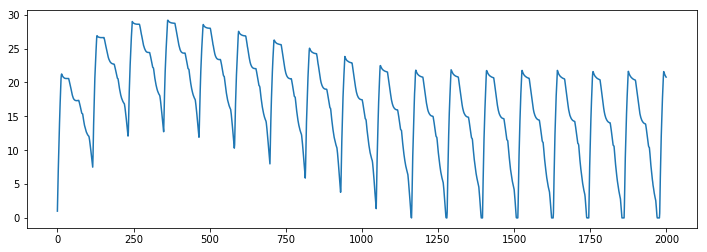

In [8]:
import_data= eval(open('snhx_file.txt', 'r').read())
plt.figure(figsize=(12,4))
plt.plot(import_data[:2000])
plt.show()

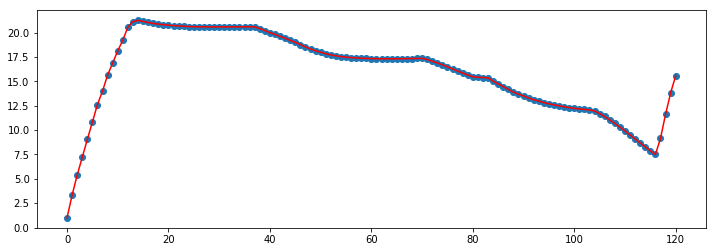

In [9]:
cal_data = import_data[:121] #(np.random.normal(-1,1,121))
plt.figure(figsize=(12,4))
plt.scatter(np.arange(121),cal_data)
plt.plot(import_data[:121],'r')
plt.show()

In [40]:
param_names=['KO2_AOB_AS', 'muAOB']
lower=np.array([1,0.2])
upper=np.array([3,1.5])
all_rss=[]

In [18]:
def model(params):
    stop_t=6*3600*1000
    dataComm = 180000
    sumo.set_stopTime(stop_t)
    sumo.set_dataComm(dataComm)
    
    no3={}
    no2={}
    snh={}

    set_cmd='set Sumo__Plant__Sumo2__'
    command=''
    #Convert internals to bounds
    #params=[0.5,1.2]
    #param=min+(np.sin(params)+1)*(max-min)/2

    #Build the Sumo command
    for j in range(len(params)):
        command +=set_cmd + param_names[j] + ' '+ str(params[j]) + '; \n'

    sumo.core.csumo_command_send(sumo.handle, command.encode('utf8'))
    
    global t, snhx, sno2,sno3
    t = []
    snhx=[[] for i in range(6)]
    sno2=[[] for i in range(6)]
    sno3=[[] for i in range(6)]
    
    sumo.run_model()

    while not sumo.simulation_finished:
            time.sleep(0.01)

    snh=np.array(snhx[0])

    tl=min(len(t), len(cal_data))
    # Define the optimization function which is the residuals sum squared (RSS)
    rss=np.sqrt(sum((snh[:tl]-cal_data[:tl])**2))
    rss_p=np.concatenate((np.array(params),np.array([rss])),axis=0)
    all_rss.append(rss_p.tolist())
    print("Evaluating the MODEL",rss_p)
    return rss      

In [45]:
%%time
#Run the model for grid samples
x= np.linspace(1,3,10)
y= np.linspace(0.2,1.5,10)
smple=[]
rss_out=np.empty((len(x),len(y)))
for i in range(len(x)):
    for j in range(len(y)):
        smple.append([x[i],y[j]])
        rss_out[i,j]=model([x[i],y[j]])

Evaluating the MODEL [  1.           0.2         82.66456258]
Evaluating the MODEL [  1.           0.34444444  74.36448942]
Evaluating the MODEL [  1.           0.48888889  67.09780391]
Evaluating the MODEL [  1.           0.63333333  60.0433085 ]
Evaluating the MODEL [  1.           0.77777778  53.15853684]
Evaluating the MODEL [  1.           0.92222222  46.04545746]
Evaluating the MODEL [  1.           1.06666667  38.71724082]
Evaluating the MODEL [  1.           1.21111111  31.44432127]
Evaluating the MODEL [  1.           1.35555556  24.35082631]
Evaluating the MODEL [  1.           1.5         17.74029972]
Evaluating the MODEL [  1.22222222   0.2         83.24379296]
Evaluating the MODEL [  1.22222222   0.34444444  75.40759824]
Evaluating the MODEL [  1.22222222   0.48888889  68.53767476]
Evaluating the MODEL [  1.22222222   0.63333333  61.92903628]
Evaluating the MODEL [  1.22222222   0.77777778  55.14108273]
Evaluating the MODEL [  1.22222222   0.92222222  48.59055176]
Evaluati

In [31]:
#res_array=np.array(list(res.values()))
with open('sim_result.txt','wb') as f:
    for a in rss_out:
        np.savetxt(f, a)
        f.write(b'\n')

In [34]:
len(X)

20

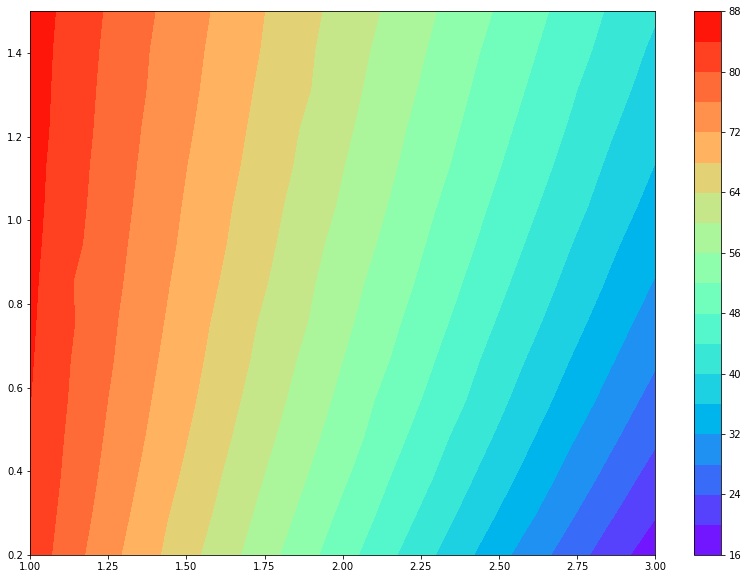

In [43]:
import scipy as sp

X, Y = np.meshgrid(x, y)
fig= plt.figure(figsize=(14,10))

ct=plt.contourf(X, Y, rss_out,20,cmap=plt.cm.rainbow)

plt.colorbar()
plt.show()

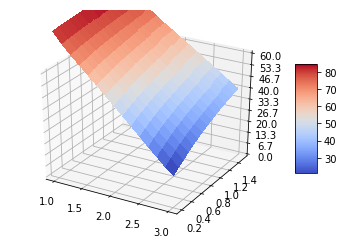

In [44]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig2 = plt.figure()
ax2 = fig2.gca(projection='3d')
surf = ax2.plot_surface(X, Y, rss_out, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax2.set_zlim(0, 60)
ax2.zaxis.set_major_locator(LinearLocator(10))
ax2.zaxis.set_major_formatter(FormatStrFormatter('%.01f'))

# Add a color bar which maps values to colors.
fig2.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

### Start the optimization process

In [11]:
x_params=[]
def store_x(xx):
    x_params.append(xx.tolist())
    

In [25]:
x0 = sp.random.uniform(min, max,size=(4,2))
x0

array([[ 0.1998928 ,  1.7757113 ],
       [ 2.47751191,  1.71465047],
       [ 1.43342187,  1.74335664],
       [ 1.76361586,  0.73487636]])

In [ ]:
%%time
res={}
par_set=np.random.randint(6, size=(50,2))
par_set=min +(max-min)*par_set/5
res_list = {} #sp.empty(5, dtype = object)
for i in range(50):
    
    # Specify initial estimates of the parameters
    p0 = par_set[i,:]
    #np.array([1, 0.5]).reshape(1,2)
    #convert them to unbounded values 
    x0=np.arcsin(2*(p0-min)/(max-min)-1)
    # We will be using Nelder-Mead simplex optimization
    res[i] = minimize(model, x0, method='nelder-mead',callback=store_x, 
                      options={'maxiter':20,'fatol':0.05,'xtol': 1e-3, 'disp': True})
    #res_list[i]=res
    #sort_res_list = res_list[sp.argsort([res.fun for res in res_list])]

In [46]:
res

 final_simplex: (array([[ 1.68860605, -0.579151  ],
       [ 1.61006623, -0.579151  ],
       [ 1.57079633, -0.64350111]]), array([ 70.74884978,  70.77012336,  72.39179646]))
           fun: 70.748849784132375
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 6
           nit: 3
        status: 2
       success: False
             x: array([ 1.68860605, -0.579151  ])

In [ ]:
#Best result
sort_res_list[0].x

In [48]:
res_array=np.array(list(res.values()))
with open('cal_result.txt','wb') as f:
    for a in car_res_array:
        np.savetxt(f, a)
        f.write(b'\n')

NameError: name 'car_res_array' is not defined

In [ ]:
car_res_array=np.array(sort_res_list)
with open('cal_result.txt','wb') as f:
    for a in car_res_array:
        np.savetxt(f, a)
        f.write(b'\n')

res_array=np.array(list(res.values()))
with open('cal_result.txt','wb') as f:
    for a in car_res_array:
        np.savetxt(f, a)
        f.write(b'\n')

In [260]:
res_x=res[0].x
convert=lambda x:(min+(np.sin(x)+1)*(max-min)/2)
res_x=convert(res_x)

In [261]:
x_array=np.array(x_params)
x_array.shape

(87, 2)

In [262]:
#Convert back to the actual bounds
x_convert=convert(x_array)

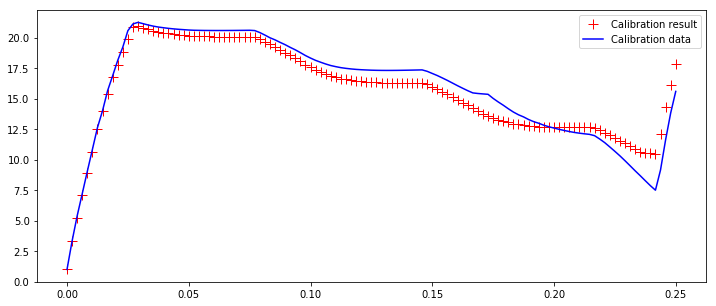

In [263]:
plt.figure(figsize=(12,5))
plt.plot(t,snhx[0],'r+', ms=10, label="Calibration result")
plt.plot(t,cal_data,'b', label="Calibration data")
plt.legend(loc="best")
plt.show()

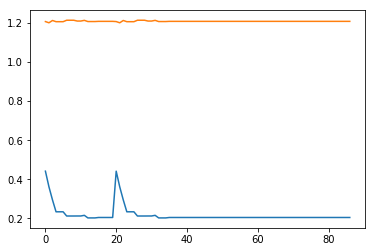

In [266]:
plt.figure()
#plt.scatter(x_convert[:,0],x_convert[:,1])
#plt.plot(res_x[0],res_x[1],'r+', ms=30)
plt.plot(x_convert[:,0])
plt.plot(x_convert[:,1])
plt.show()

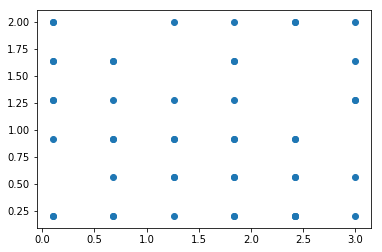

In [272]:
par_set=np.random.randint(6, size=(50,2))
#delta=[0.1,0.3]
par_set=min +(max-min)*par_set/5
plt.figure()
plt.scatter(par_set[:,0],par_set[:,1])
plt.show()